<a href="https://colab.research.google.com/github/aryandaga7/MaterialScienceResearch/blob/main/Materials_Science_ML_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip uninstall numpy

# !pip install numpy
# !pip install --upgrade numpy


Found existing installation: numpy 1.26.1
Uninstalling numpy-1.26.1:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.10/dist-packages/numpy-1.26.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.26.1
  Using cached numpy-1.26.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 

In [ ]:
# !pip uninstall -y pymatgen
# !pip install pymatgen

In [1]:
import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.core.structure import Structure
from pymatgen.analysis import structure_matcher
import matplotlib.pyplot as plt
from pymatgen.io.vasp import Poscar
import os
from pymatgen.core.periodic_table import Element
from pymatgen.core.periodic_table import Species

In [2]:
ideal_list_of_material_ids = {"LGPS (Li10GeP2S12)":"mp-696128", "Li7P3S11":"mp-641703", "LLZO (Li7La3Zr2O12)": "mp-942733", "β-Li3PS4": "mp-1097036"}
non_ideal_list_of_material_ids = {"Lithium titanium phosphate (LiTi2(PO4)3)":"mp-18640", "LiAlSi2O6 (Spodumene)": "mp-558808", "Li3ClO": "mp-985585", "LiH": "mp-23703"}


In [3]:
api_key = 'lNziq0zLp7W2war5i8hZ9aAC7vQLSRZy'
mpr = MPRester(api_key)

In [ ]:
# Function to save VESTA files
def save_vesta_files(material_ids, folder='vesta_files'):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for name, mp_id in material_ids.items():
        structure = mpr.get_structure_by_material_id(mp_id)
        poscar = Poscar(structure)
        with open(os.path.join(folder, f"{name}.vesta"), "w") as f:
            f.write(poscar.get_string())
    print(f"VESTA files saved in {folder} folder")

# Save VESTA files for ideal and non-ideal candidates
save_vesta_files(ideal_list_of_material_ids)
save_vesta_files(non_ideal_list_of_material_ids)

In [ ]:
# # Install necessary visualization packages
# !pip install crystal-toolkit
# !pip install panel
# !pip install --upgrade param
# !jupyter nbextension install --py crystal_toolkit --sys-prefix
# !jupyter nbextension enable --py crystal_toolkit --sys-prefix

In [47]:
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifWriter

def save_cif_files(material_ids, folder='cif_files'):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for name, mp_id in material_ids.items():
        structure = mpr.get_structure_by_material_id(mp_id)
        cif_writer = CifWriter(structure)
        cif_writer.write_file(f"{folder}/{name}.cif")
    print(f"CIF files saved in {folder} directory.")

# Save CIF files for ideal Li compounds
save_cif_files(ideal_list_of_material_ids)

CIF files saved in cif_files directory.


In [ ]:
# Install py3Dmol
!pip install py3Dmol

import py3Dmol

def view_structure(path):
    with open(path, 'r') as file:
        cif = file.read()

    view = py3Dmol.view(width=800, height=400)
    view.addModel(cif, 'cif')
    view.setStyle({'stick': {}})
    view.zoomTo()
    return view

# Specify the path to the file
file_path = '/content/cif_files/LGPS (Li10GeP2S12).cif'

# View the structure
view = view_structure(file_path)
view.show()

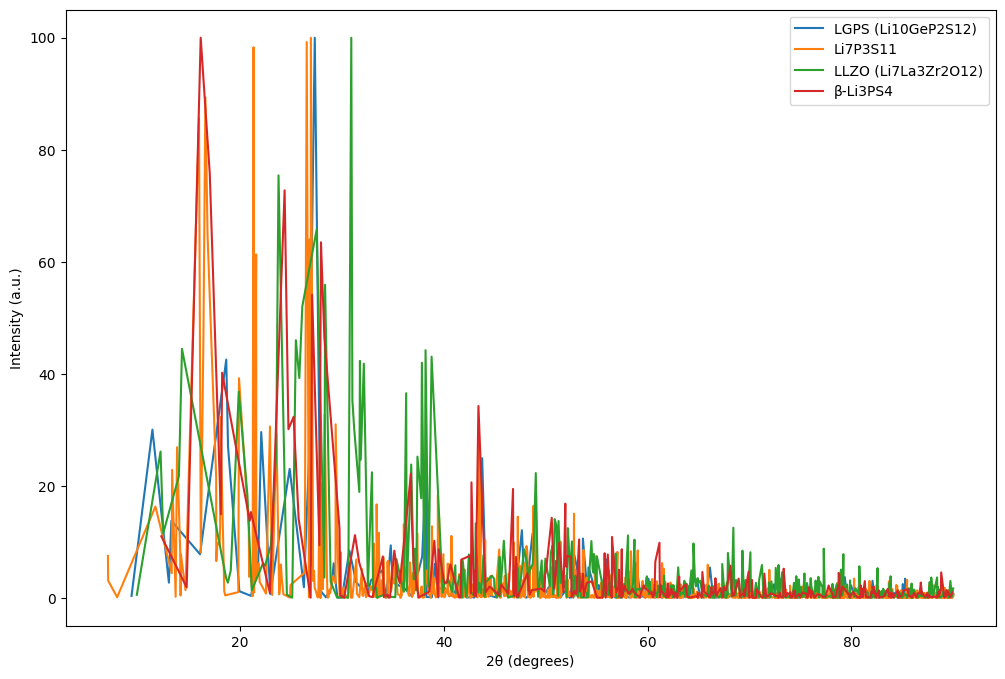

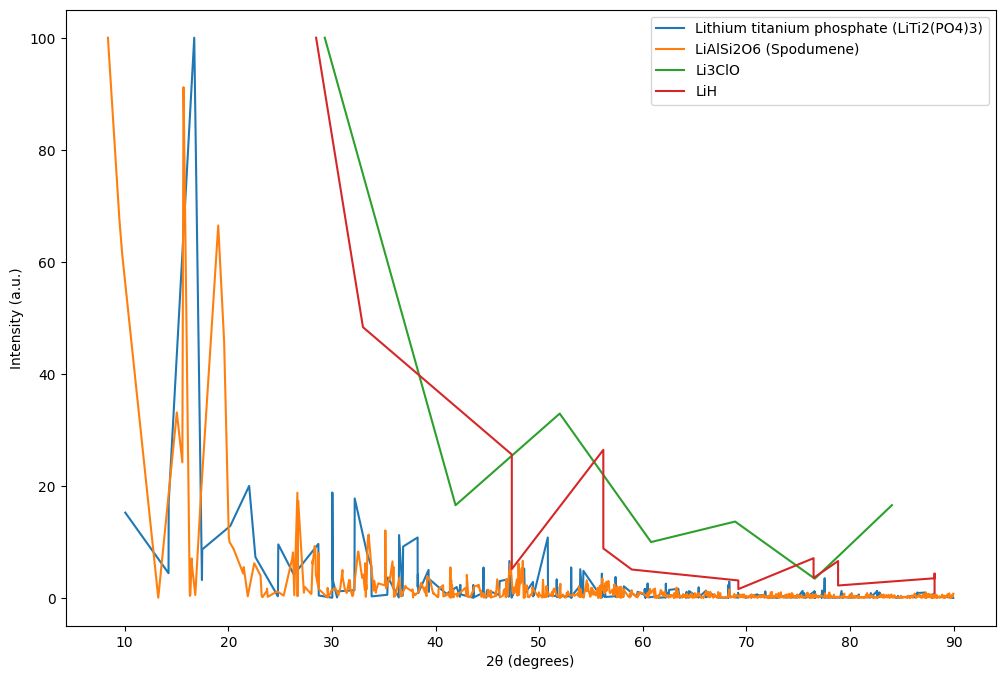

In [45]:
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.core.periodic_table import DummySpecies
from scipy.ndimage import gaussian_filter1d

def normalize_anion_sublattice(structure, target_volume_per_anion, substitute_anion='S', oxidation_state=-2):
    # Remove cations and create a new structure with only anions
    anions_only_structure = Structure.from_sites([site for site in structure if site.specie != Element("Li")])

    # Substitute all anions with S2-
    for site in anions_only_structure:
        site.species = {Species(substitute_anion, oxidation_state): 1}

    # Normalize volume
    current_volume_per_anion = anions_only_structure.volume / len(anions_only_structure)
    scaling_factor = (target_volume_per_anion / current_volume_per_anion) ** (1/3)
    anions_only_structure.scale_lattice(anions_only_structure.volume * scaling_factor ** 3)

    return anions_only_structure


# Function to calculate mXRD patterns with Gaussian smearing
def calculate_mXRD_patterns_with_smearing(material_ids, target_volume_per_anion, substitute_anion='S', oxidation_state=-2, smearing=0.1):
    mXRD_patterns = []
    xrd_calculator = XRDCalculator(wavelength='CuKa')
    fig, ax = plt.subplots(figsize=(12, 8))

    for name, mp_id in material_ids.items():
        structure = mpr.get_structure_by_material_id(mp_id)
        anion_structure = normalize_anion_sublattice(structure, target_volume_per_anion, substitute_anion)
        pattern = xrd_calculator.get_pattern(anion_structure)
        smeared_intensity = gaussian_filter1d(pattern.y, sigma=smearing)
        mXRD_patterns.append(smeared_intensity)  # Store the smeared intensities
        ax.plot(pattern.x, pattern.y, label=name)
    ax.set_xlabel('2θ (degrees)')
    ax.set_ylabel('Intensity (a.u.)')
    ax.legend()
    plt.show()

    return mXRD_patterns

# Define the target volume per anion
target_volume_per_anion = 40.0  # in Å³

# Calculate mXRD patterns for ideal and non-ideal candidates
ideal_mXRD_patterns = calculate_mXRD_patterns_with_smearing(ideal_list_of_material_ids, target_volume_per_anion)
non_ideal_mXRD_patterns = calculate_mXRD_patterns_with_smearing(non_ideal_list_of_material_ids, target_volume_per_anion)

# Combine the patterns and labels
all_mXRD_patterns = ideal_mXRD_patterns + non_ideal_mXRD_patterns
labels = ['Ideal'] * len(ideal_mXRD_patterns) + ['Non-Ideal'] * len(non_ideal_mXRD_patterns)

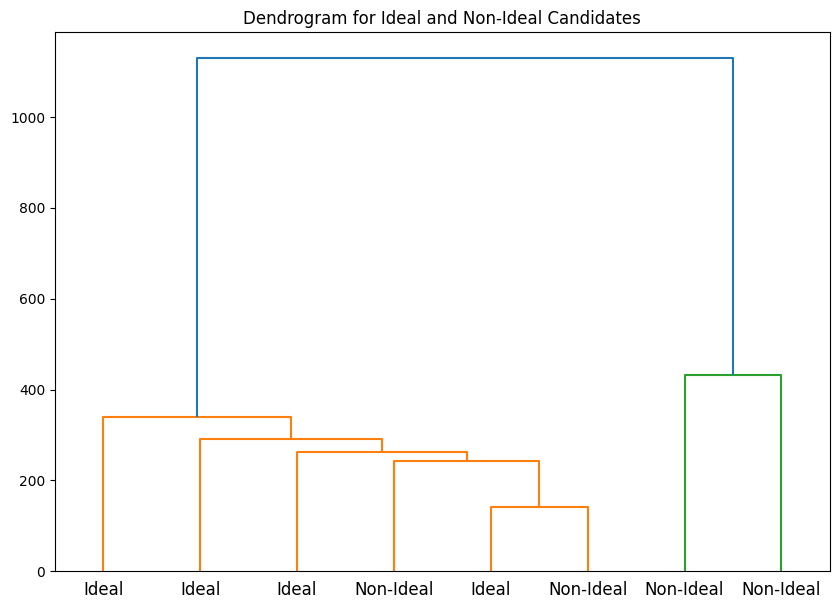

In [42]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

# Function to plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # original sample
            else:
                current_count += counts[child_idx - n_samples]  # previously formed cluster
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Function to interpolate data
def interpolate_data(data, target_length=1000):
    interpolated_data = []
    for d in data:
        x = np.arange(len(d))
        f = interp1d(x, d, kind='linear')
        x_new = np.linspace(0, len(d) - 1, target_length)
        y_new = f(x_new)
        interpolated_data.append(y_new)
    return np.array(interpolated_data)

# Combine the mXRD patterns and labels from ideal and non-ideal compounds
all_mXRD_patterns = ideal_mXRD_patterns + non_ideal_mXRD_patterns
labels = ['Ideal'] * len(ideal_mXRD_patterns) + ['Non-Ideal'] * len(non_ideal_mXRD_patterns)

# Interpolate mXRD data to the same length
interpolated_mXRD_data = interpolate_data(all_mXRD_patterns)

# Perform hierarchical clustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model = model.fit(interpolated_mXRD_data)

# Create the linkage matrix using the ward clustering performed by the AgglomerativeClustering
linkage_matrix = ward(interpolated_mXRD_data)

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Dendrogram for Ideal and Non-Ideal Candidates')
dendrogram(linkage_matrix, labels=labels)
plt.show()
